Imports

In [1]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import collections
%matplotlib inline

import sklearn as sk
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from time import time
from scipy import ndimage
from sklearn import manifold

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import operator
import pickle as pk
from sklearn.cluster import AgglomerativeClustering

from itertools import chain
import numpy.linalg as LA
from scipy.spatial.distance import pdist

In [2]:
original_dataset_digits = pd.read_csv('DatasetChampionIndices.csv')

In [3]:
with open('ChampionsAllInfo.pkl', 'rb') as inp:
    champions = pk.load(inp)
    
# champion stats normalization and preprocessing
# Standard Normalization (x-mean(x) / std(x))
STAT = True
champions_stats = []
for i in range(len(champions)):
    if STAT:
        stat = champions[i]['stats']
        champions_stats.append([stat['hp'], stat['attackdamage'], stat['armor'], stat['spellblock'], stat['movespeed'], stat['attackrange'], stat['hpregen']])
    else:
        info = champions[i]['info']
        champions_stats.append([info['attack'], info['defense'], info['difficulty'], info['magic']])
min_max_scaler = preprocessing.StandardScaler()
champions_stats_normalized = min_max_scaler.fit_transform(champions_stats)

making the dataset in 0-1 format

In [4]:
original_dataset = []
for sample in original_dataset_digits.as_matrix()[:,:-1]:
    if np.any(sample > 131) or np.any(sample < 0):
        continue
    w = np.zeros(132)
    for s in sample[:5]:
        w[int(s)] = 1
    l = np.zeros(132)
    for s in sample[5:]:
        l[int(s)] = 1
    original_dataset.append(np.hstack((w,l)))

In [5]:
dataset = pd.DataFrame(original_dataset)
dataset = dataset.sample(n=10000, replace=False)

In [6]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,254,255,256,257,258,259,260,261,262,263
8308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1146,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17224,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Champion counts chosen by winners and losers

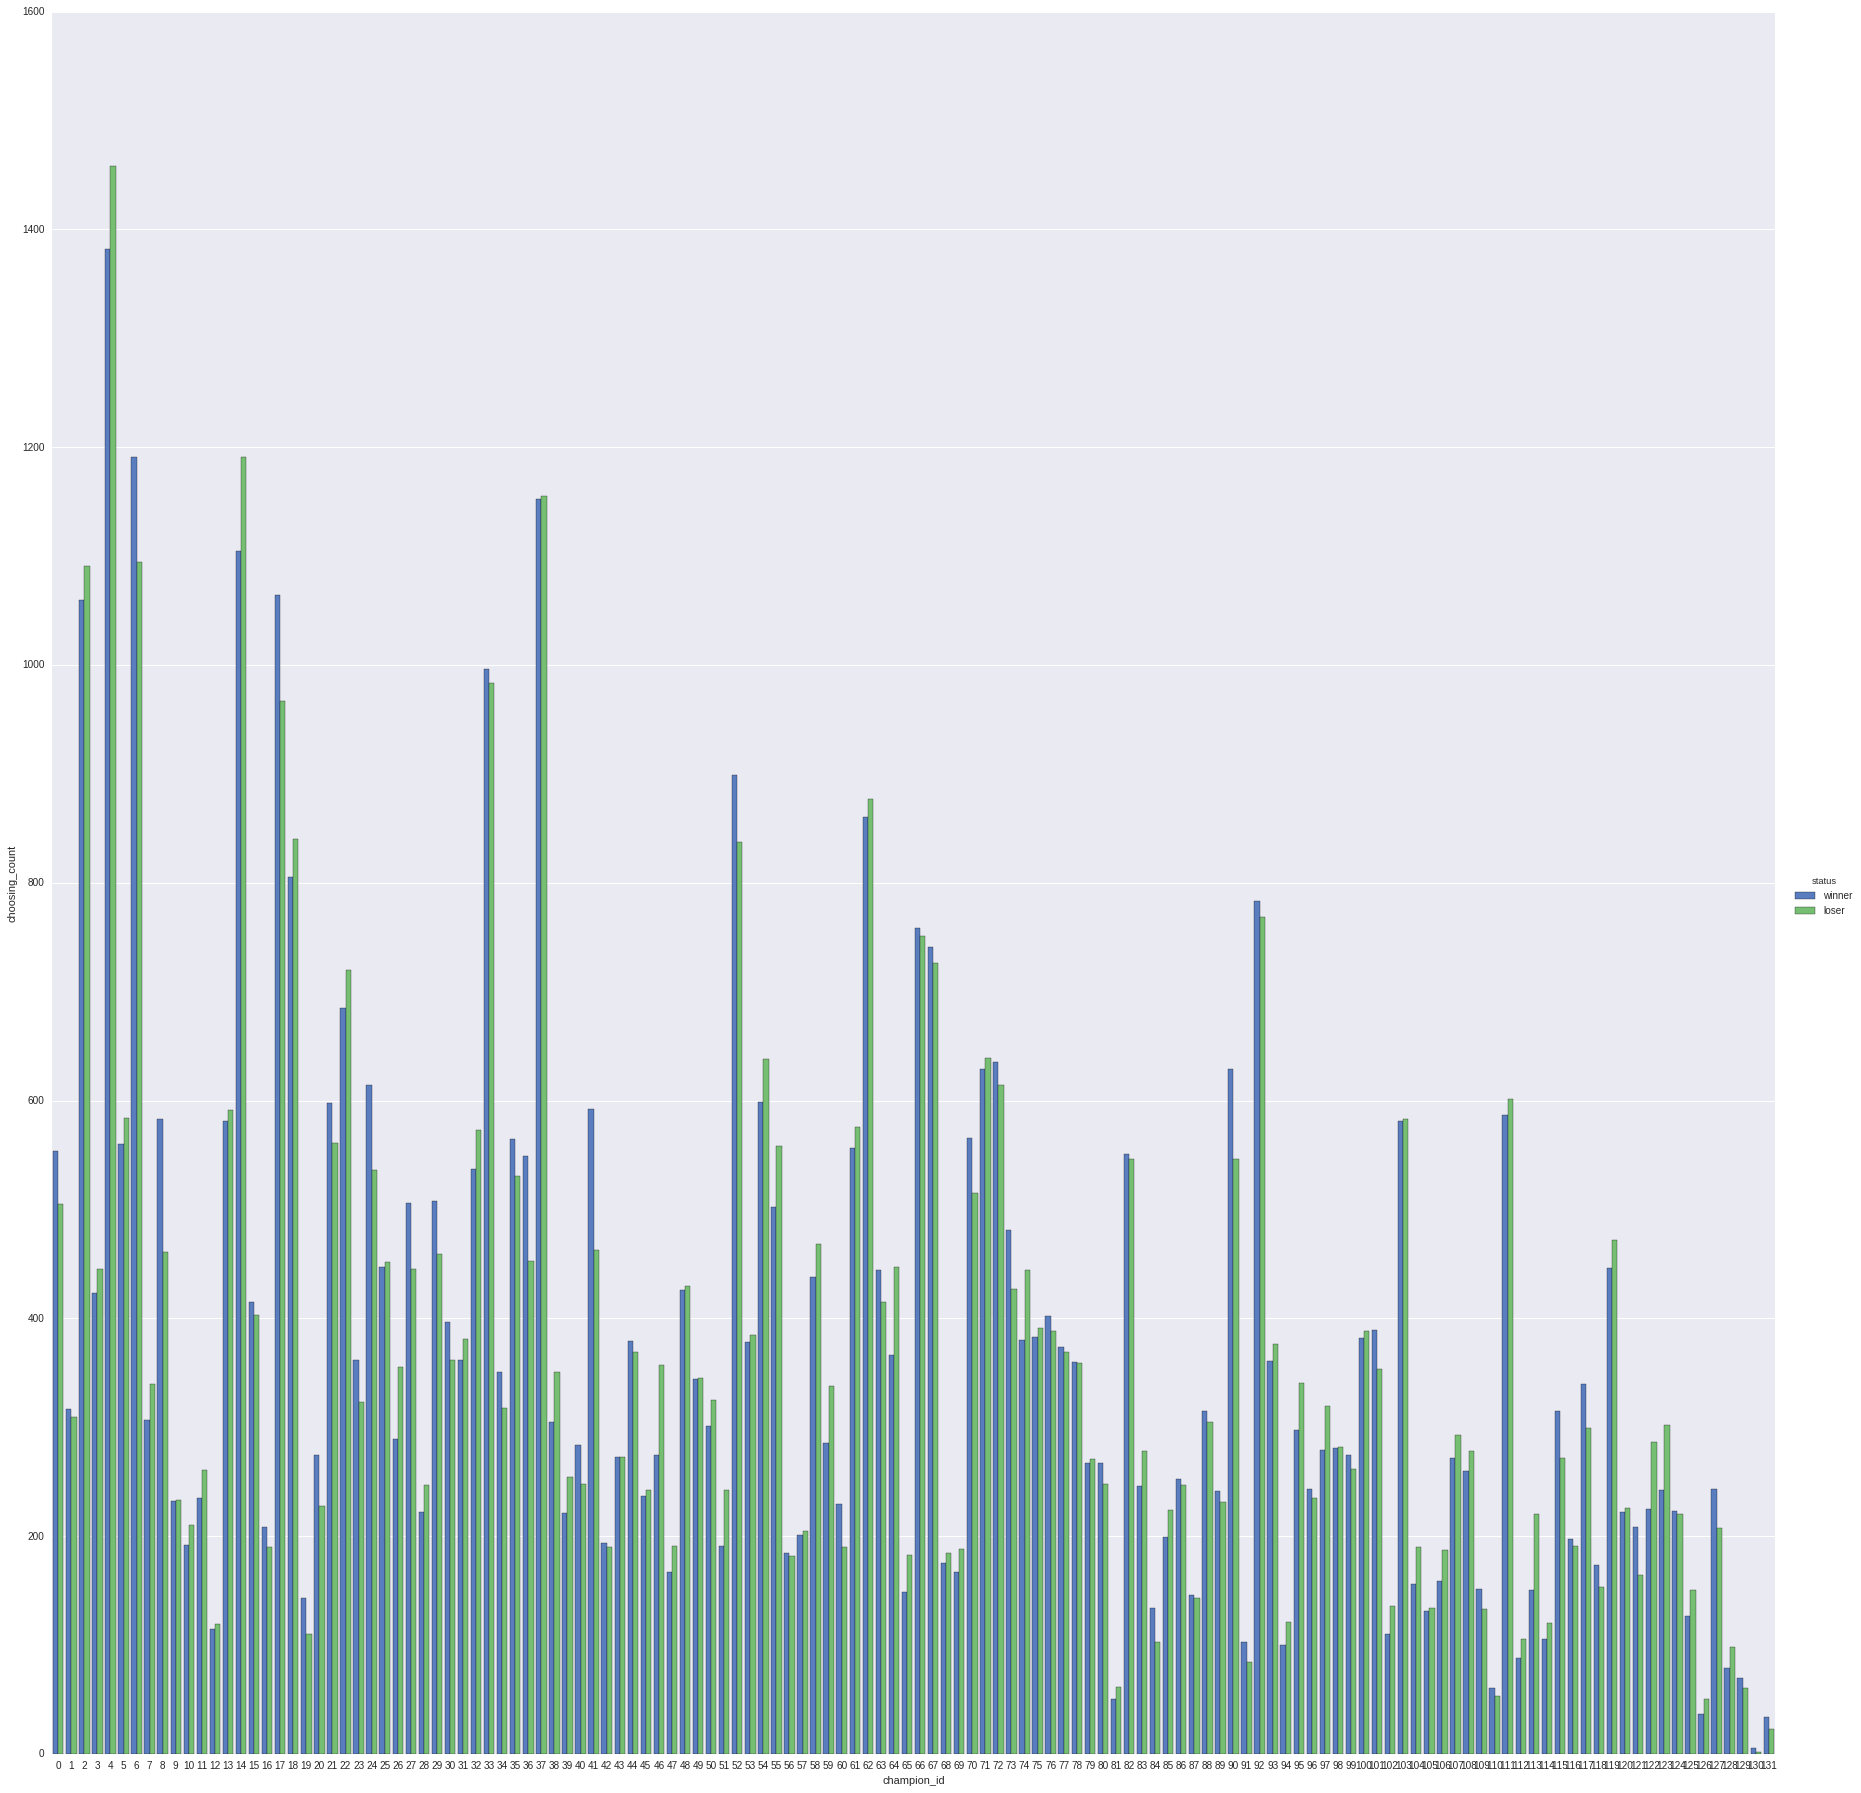

In [7]:
all_winners = dataset.ix[:,:131].as_matrix()
all_losers = dataset.ix[:,132:].as_matrix()
all_counts = []
for i in range(132):
    all_counts.append([i, len(np.where(all_winners[:,i]==1)[0]), 'winner'])
for i in range(132):
    all_counts.append([i, len(np.where(all_losers[:,i]==1)[0]), 'loser'])
dt = pd.DataFrame(all_counts, columns=['champion_id', 'choosing_count', 'status'])

g = sns.factorplot(x="champion_id", y="choosing_count", hue="status", data=dt,
                   size=25, kind="bar", palette="muted")

Now dataset is ready for classification

In [105]:
# %load do_classification.py
#Omid55
def do_classification(dataset):
    
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import cross_validation
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn import svm
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    from sklearn.linear_model import SGDClassifier
    from sklearn.dummy import DummyClassifier

    if type(dataset) is pd.core.frame.DataFrame:
        dataset = dataset.as_matrix()

    #clf = MLPClassifier(algorithm='l-bfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    models = [(DummyClassifier(strategy='stratified'), 'Dummy (Stratified)'),
        (DummyClassifier(strategy='uniform'), 'Dummy (Uniform)'),
        (SGDClassifier(), 'Stochastic Gradient Descent Classifier'),
        (LogisticRegression(), 'Logistic Regression'),
        (GaussianNB(), 'Naive Bayes'),
        (svm.LinearSVC(C=1.0, verbose=False), 'Linear SVM'),
        (svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False), 'SVM with RBF kernel'),
        (RandomForestClassifier(n_estimators=100), 'Random Forest'),
        (KNeighborsClassifier(n_neighbors=8), 'KNN'),
        (DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
        (AdaBoostClassifier(), 'AdaBoost'),
        (LinearDiscriminantAnalysis(), 'Linear Discriminant Analysis'),
        (QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant Analysis')]
    
    # applying the models
    n_folds = 10
    k_fold = cross_validation.KFold(n=len(dataset), n_folds=n_folds, shuffle=False, random_state=None)
    accuracy = {}
    train_accuracy = {}
    for train_index, test_index in k_fold:
        X_train = dataset[train_index,:-1]
        y_train = dataset[train_index,-1]
        X_test = dataset[test_index,:-1]
        y_test = dataset[test_index,-1]

        for clf, name in models:
            clf.fit(X_train, y_train)

            # test data accuracy
            y_pred = clf.predict(X_test)
            accuracy_percent = 100 * sk.metrics.accuracy_score(y_test, y_pred) / n_folds
            if name not in accuracy:
                accuracy[name] = accuracy_percent
            else:
                accuracy[name] += accuracy_percent

            # train data accuracy
            y_train_pred = clf.predict(X_train)
            train_accuracy_percent = 100 * sk.metrics.accuracy_score(y_train, y_train_pred) / n_folds
            if name not in train_accuracy:
                train_accuracy[name] = train_accuracy_percent
            else:
                train_accuracy[name] += train_accuracy_percent
        result = []
        for key in accuracy.keys():
            result.append([key, round(accuracy[key],2), round(train_accuracy[key],2)])
        result_accuracy_df = pd.DataFrame(data=result, columns=['classifier', 'test acc', 'train acc'])
    return result_accuracy_df

In [143]:
dataset_sampled = dataset.sample(n=4000, replace=False)

In [193]:
# %load plot_data.py
# Omid55
def plot_data(data, has_label=True):
	import numpy as np
	from sklearn.manifold import TSNE
	from sklearn.decomposition import PCA

	if not has_label:
		data = data.copy()
		data['label'] = np.zeros([len(data),1])

	LIMIT = 4000
	if data.shape[0] > LIMIT:
		dt = data.sample(n=LIMIT, replace=False)
		X = dt.ix[:,:-1]
		labels = dt.ix[:,-1]
	else:
		X = data.ix[:,:-1]
		labels = data.ix[:,-1]

	tsne_model = TSNE(n_components=2, random_state=0)
	np.set_printoptions(suppress=True)
	points1 = tsne_model.fit_transform(X)
	df1 = pd.DataFrame(data=np.column_stack([points1,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df1, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('TNSE')

	pca = PCA(n_components=2)
	pca.fit(X)
	points2 = pca.transform(X)
	df2 = pd.DataFrame(data=np.column_stack([points2,labels]), columns=["x","y","class"])
	sns.lmplot("x", "y", data=df2, hue='class', fit_reg=False, palette=sns.color_palette('colorblind'))
	sns.plt.title('PCA')



In [219]:
# %load print_class_ratio.py
# Omid55
def print_class_ratio(data):
	assert 'label' in data, 'The dataset does not have required label column.'
	labels = set(data['label'])
	print('Data has', len(data), 'samples,')
	for l in labels:
		print(int(l),': ', 100 * len(np.where(data['label'] == l)[0]) / len(data), '%')

Classification on whole dataset and just with 9 clusters

In [227]:
# %load add_balanced_labels.py
# Omid55
'''
Adding label and swapping 50% of winners and losers; Thus:
label 0 == winner + loser
label 1 == loser + winner
'''
def add_balanced_labels(data, one_ratio=0.5):
    data_copied = pd.DataFrame(data).copy()
    data_copied['label'] = np.zeros([len(data_copied),1])
    dt = data_copied.as_matrix()
    idx = np.random.choice(len(dt), int(len(dt)*one_ratio), replace=False)
    tf = math.floor(dt.shape[1]/2)
    tmp = dt[idx,tf:2*tf]
    dt[idx,tf:2*tf] = dt[idx,:tf]
    dt[idx,:tf] = tmp
    dt[idx,-1] = 1
    #result = pd.DataFrame(data=dt, columns=data.columns)
    return data_copied

classification on entire dataset

In [145]:
import warnings
warnings.filterwarnings('ignore')

print('Classification on whole dataset:')
do_classification(add_balanced_labels(dataset_sampled))

Classification on whole dataset:


,classifier,test acc,train acc
0,Quadratic Discriminant Analysis,51.45,88.52
1,Stochastic Gradient Descent Classifier,50.92,55.96
2,AdaBoost,50.75,59.09
3,Naive Bayes,51.50,61.14
4,Decision Tree,50.25,54.68
5,Dummy (Stratified),48.10,49.75
6,Linear Discriminant Analysis,53.30,63.07
7,Logistic Regression,53.52,63.10
8,SVM with RBF kernel,52.08,59.82
9,KNN,51.45,64.53


9 Clusters

Computing embedding
Done.
average : 17.84s
complete : 17.42s


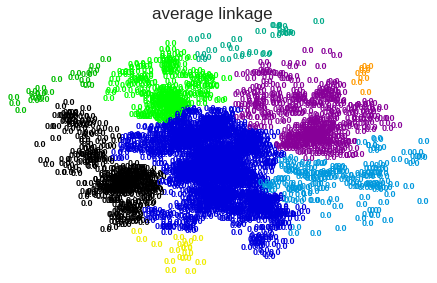

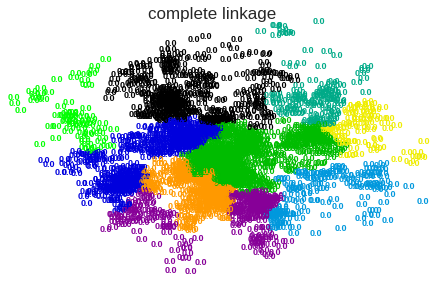

In [242]:
visualize_hierarchical_clusters(ds, 9)

In [146]:
NUMBER_OF_CLUSTERS = 9

X = dataset_sampled.as_matrix()
for linkage in ('average', 'complete'):
    accuracies = collections.defaultdict(lambda: 0)
    print('Linkage is', linkage, '=>\n\n')
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=NUMBER_OF_CLUSTERS, affinity='cosine')
    clustering.fit(X)
    for cluster_index in range(NUMBER_OF_CLUSTERS):
        idx = np.where(clustering.labels_==cluster_index)[0]
        print('Length of this cluster is:', len(idx),'\n')
        if len(idx) > 10:
            print(do_classification(add_balanced_labels(X[idx,:])))
            print('\n----------------------------------------------\n')
    print('\n\n\n================================================')

Linkage is average =>


Length of this cluster is: 1552 

                                classifier  test acc  train acc
0          Quadratic Discriminant Analysis     59.86      91.39
1   Stochastic Gradient Descent Classifier     73.52      80.66
2                                 AdaBoost     77.83      81.96
3                              Naive Bayes     63.85      76.06
4                            Decision Tree     73.77      78.21
5                       Dummy (Stratified)     49.16      49.96
6             Linear Discriminant Analysis     76.48      86.20
7                      Logistic Regression     77.06      86.89
8                      SVM with RBF kernel     78.99      82.50
9                                      KNN     74.80      82.70
10                         Dummy (Uniform)     50.78      49.91
11                              Linear SVM     75.38      87.06
12                           Random Forest     79.00     100.00

---------------------------------------------

Length of this cluster is: 125 



,classifier,test acc,train acc
0,Quadratic Discriminant Analysis,59.29,100.00
1,Stochastic Gradient Descent Classifier,90.38,99.91
2,AdaBoost,90.45,100.00
3,Naive Bayes,79.23,98.05
4,Decision Tree,90.58,97.78
5,Dummy (Stratified),58.65,48.98
6,Linear Discriminant Analysis,75.96,92.54
7,Logistic Regression,92.69,100.00
8,SVM with RBF kernel,35.90,51.55
9,KNN,87.95,94.67


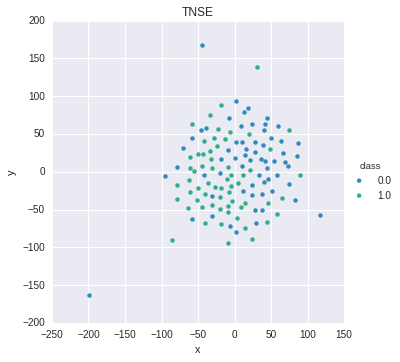

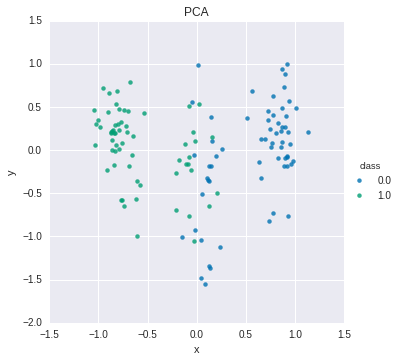

In [333]:
chosen_index = 6
NUMBER_OF_CLUSTERS = 9
clustering = AgglomerativeClustering(linkage='average', n_clusters=NUMBER_OF_CLUSTERS, affinity='cosine')
clustering.fit(X)
idx = np.where(clustering.labels_==chosen_index)[0]
print('Length of this cluster is:', len(idx),'\n')
cluster_data = X[idx,:]
c6 = add_balanced_labels(cluster_data)
plot_data(c6)
do_classification(c6)

# diversity in terms of champion features

In [314]:
# %load plot_diversity.py
# Omid55
def plot_diversity(data, metric='euclidean'):

    if data.shape[1] == 265:
        winners = [match[:132] if not match[-1] else match[132:-1] for match in data]
        losers = [match[132:-1] if not match[-1] else match[:132] for match in data]
    else:
        winners = [match[:131] for match in data]
        losers = [match[132:] for match in data]

    winner_distance = [compute_average_distance([champions_stats_normalized[champ_id] for champ_id in np.where(winner == 1)[0]], metric=metric) for winner in winners]
    loser_distance = [compute_average_distance([champions_stats_normalized[champ_id] for champ_id in np.where(loser == 1)[0]], metric=metric) for loser in losers]

    plt.hist(winner_distance)
    plt.hist(loser_distance)
    plt.legend(['winners', 'losers'])
    plt.title(metric)
    plt.show()
    

def compute_average_distance(team, metric):
    return np.average(pdist(team, metric=metric))

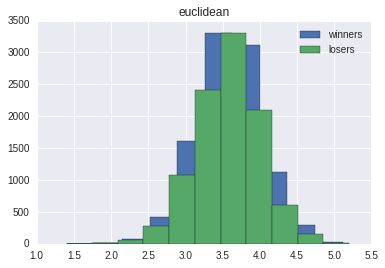

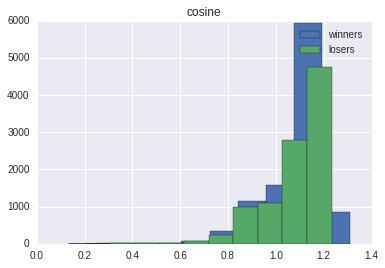

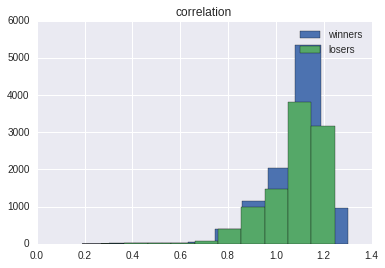

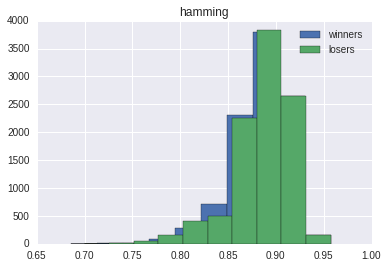

In [331]:
#for all data
plot_diversity(dataset.as_matrix(), metric='euclidean')
plot_diversity(dataset.as_matrix(), metric='cosine')
plot_diversity(dataset.as_matrix(), metric='correlation')
plot_diversity(dataset.as_matrix(), metric='hamming')

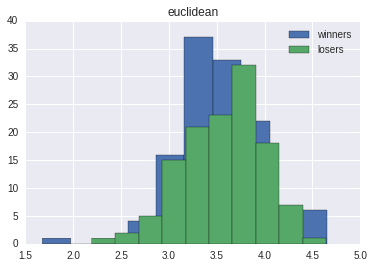

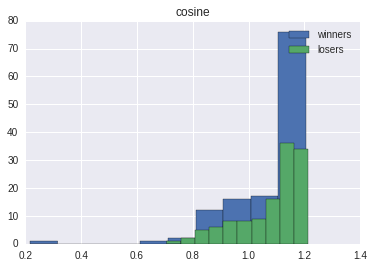

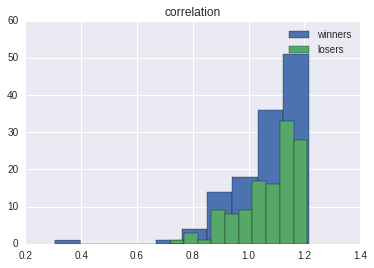

In [336]:
#one cluser with 125 samples
plot_diversity(cluster_data, metric='euclidean')
plot_diversity(cluster_data, metric='cosine')
plot_diversity(cluster_data, metric='correlation')

Data has 125 samples,
0 :  80.0 %
1 :  20.0 %


,classifier,test acc,train acc
0,Quadratic Discriminant Analysis,38.27,100.00
1,Stochastic Gradient Descent Classifier,94.36,99.91
2,AdaBoost,87.12,100.00
3,Naive Bayes,79.94,99.38
4,Decision Tree,94.55,97.25
5,Dummy (Stratified),70.32,68.81
6,Linear Discriminant Analysis,82.37,94.76
7,Logistic Regression,91.15,100.00
8,SVM with RBF kernel,79.94,80.00
9,KNN,83.27,84.98


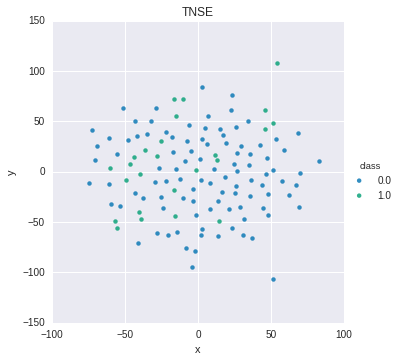

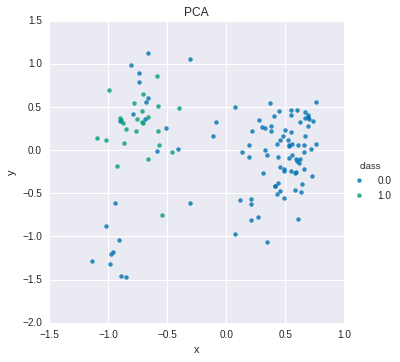

In [337]:
c6_02 = add_balanced_labels(cluster_data, one_ratio=0.2)
print_class_ratio(c6_02)
plot_data(c6_02)
do_classification(c6_02)